In [1]:
import os
import pandas as pd
import numpy as np
import pydicom
import matplotlib.pyplot as plt
import cv2
import glob

In [2]:
!unzip -q /kaggle/input/lsdc-gen-yolo-data-nfn/data_fold0.zip

In [3]:
ls

__notebook__.ipynb  data_fold0/


In [4]:
IMG_DIR = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images'

In [5]:
FOLD = 0
OD_INPUT_SIZE = 384
STD_BOX_SIZE = 20
BATCH_SIZE = 16
EPOCHS = 100

SAMPLE = None
CONDITIONS = ['Left Neural Foraminal Narrowing', 'Right Neural Foraminal Narrowing']
SEVERITIES = ['Normal/Mild', 'Moderate', 'Severe']
LEVELS = ['l1_l2', 'l2_l3', 'l3_l4', 'l4_l5', 'l5_s1']

DATA_DIR = f'data_fold{FOLD}'

In [6]:
train_val_df = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train.csv')
train_xy = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_label_coordinates.csv')
train_des = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_series_descriptions.csv')

In [7]:
if SAMPLE:
    train_val_df = train_val_df.sample(SAMPLE, random_state=2698)

In [8]:
fold_df = pd.read_csv('lsdc-fold-split/5folds.csv')

In [9]:
train_xy.head(3)

,study_id,series_id,instance_number,condition,level,x,y
0,4003253,702807833,8,Spinal Canal Stenosis,L1/L2,322.831858,227.964602
1,4003253,702807833,8,Spinal Canal Stenosis,L2/L3,320.571429,295.714286
2,4003253,702807833,8,Spinal Canal Stenosis,L3/L4,323.030303,371.818182


In [10]:
def get_level(text):
    for lev in ['l1_l2', 'l2_l3', 'l3_l4', 'l4_l5', 'l5_s1']:
        if lev in text:
            split = lev.split('_')
            split[0] = split[0].capitalize()
            split[1] = split[1].capitalize()
            return '/'.join(split)
    raise ValueError('Level not found ' + lev)

def get_condition(text):
    split = text.split('_')
    for i in range(len(split)):
        split[i] = split[i].capitalize()
    split = split[:-2]
    return ' '.join(split)

In [11]:
train_xy['condition'].unique()

array(['Spinal Canal Stenosis', 'Right Neural Foraminal Narrowing',
       'Left Neural Foraminal Narrowing', 'Left Subarticular Stenosis',
       'Right Subarticular Stenosis'], dtype=object)

In [12]:
label_df = {'study_id': [], 'condition': [], 'level' : [], 'label ': []}

for i, row in train_val_df.iterrows():
    study_id = row['study_id']
    for k, label in row.iloc[1:].to_dict().items():
        level = get_level(k)
        condition = get_condition(k)
        label_df['study_id'].append(study_id)
        label_df['condition'].append(condition)
        label_df['level'].append(level)
        label_df['label'].append(label)

label_df = pd.DataFrame(label_df)
label_df = label_df.merge(fold_df, on='study_id')

In [13]:
train_xy = train_xy.merge(train_des, how='inner', on=['study_id', 'series_id'])
label_df = label_df.merge(train_xy, how='inner', on=['study_id', 'condition', 'level'])

In [14]:
def query_train_xy_row(study_id, series_id=None, instance_num=None):
    if series_id is not None and instance_num is not None:
        return label_df[(label_df.study_id == study_id) & (label_df.series_id == series_id) &
                        (label_df.instance_number == instance_num)]
    elif series_id is None and instance_num is None:
        return label_df[(label_df.study_id == study_id)]
    else:
        return label_df[(train_xy.study_id == study_id) & (label_df.series_id == series_id)]

In [15]:
def read_dcm(src_path):
    dicom_data = pydicom.dcmread(src_path)
    image = dicom_data.pixel_array
    image = (image - image.min()) / (image.max() - image.min() + 1e-6) * 255
    image = np.stack([image] * 3, axis=-1).astype('uint8')
    return image

def get_accronym(text):
    split = text.split(' ')
    return ''.join([x[0] for x in split])

In [16]:
ex = label_df.sample(1).iloc[0]
study_id = ex.study_id
series_id = ex.series_id
instance_num = ex.instance_number

WIDTH = 10

path = os.path.join(IMG_DIR, str(study_id), str(series_id), f'{instance_num}.dcm')

In [17]:
img = read_dcm(path)

tmp_df = query_train_xy_row(study_id, series_id, instance_num)
for i, row in tmp_df.iterrows():
    lbl = f'{get_accronym(row['condition'])}_{row['level']}'
    x, y = row['x'], row['y']
    x1 = int(x - WIDTH)
    x2 = int(x + WIDTH)
    y1 = int(y - WIDTH)
    y2 = int(y + WIDTH)
    color = None
    if row['label'] == 'Normal/Mild':
        color = (0, 255, 0)
    elif row['label'] == 'Moderate':
        color = (255, 255, 0)
    elif row['label'] == 'Severe':
        color = (255, 0, 0)

    fontFace = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 0.5
    thickness = 1
    cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
    cv2.putText(img, lbl, (x1, y1), fontFace, fontScale, color, thickness, cv2.LINE_AA)

tmp_df

,study_id,condition,level,label,fold,series_id,instance_number,x,y,series_description
16949,1524089207,Left Subarticular Stenosis,L2/L3,NaN,4,2221300812,12,128.928463,129.363775,Axial T2


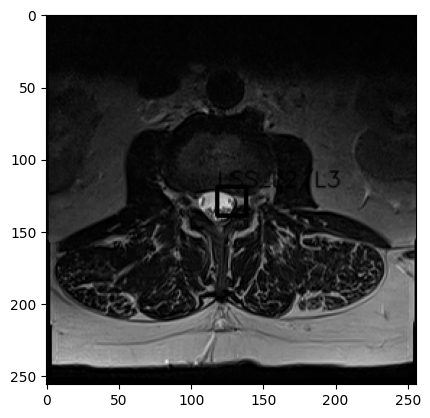

In [18]:
plt.imshow(img)
plt.show()

In [19]:
def read_dcm(src_path):
    dicom_data = pydicom.dcmread(src_path)
    image = dicom_data.pixel_array
    image = (image - image.min()) / (image.max() - image.min() + 1e-6) * 255
    image = np.stack([image] * 3, axis=-1).astype('uint8')
    return image

In [20]:
filtered_df = label_df[label_df.condition.map(lambda x: x in CONDITIONS)]

In [21]:
label2id = {}
id2label = {}
i = 0
for cond in CONDITIONS:
    for level in LEVELS:
        for severity in SEVERITIES:
            cls_ = f'{cond.lower().replace(' ', '_')}_{level}_{severity.lower()}'
            label2id[cls_] = i
            id2label[i] = cls_
            i += 1

In [22]:
id2label

{0: 'left_neural_foraminal_narrowing_l1_l2_normal/mild',
 1: 'left_neural_foraminal_narrowing_l1_l2_moderate',
 2: 'left_neural_foraminal_narrowing_l1_l2_severe',
 3: 'left_neural_foraminal_narrowing_l2_l3_normal/mild',
 4: 'left_neural_foraminal_narrowing_l2_l3_moderate',
 5: 'left_neural_foraminal_narrowing_l2_l3_severe',
 6: 'left_neural_foraminal_narrowing_l3_l4_normal/mild',
 7: 'left_neural_foraminal_narrowing_l3_l4_moderate',
 8: 'left_neural_foraminal_narrowing_l3_l4_severe',
 9: 'left_neural_foraminal_narrowing_l4_l5_normal/mild',
 10: 'left_neural_foraminal_narrowing_l4_l5_moderate',
 11: 'left_neural_foraminal_narrowing_l4_l5_severe',
 12: 'left_neural_foraminal_narrowing_l5_s1_normal/mild',
 13: 'left_neural_foraminal_narrowing_l5_s1_moderate',
 14: 'left_neural_foraminal_narrowing_l5_s1_severe',
 15: 'right_neural_foraminal_narrowing_l1_l2_normal/mild',
 16: 'right_neural_foraminal_narrowing_l1_l2_moderate',
 17: 'right_neural_foraminal_narrowing_l1_l2_severe',
 18: 'right

In [23]:
train_df = filtered_df[filtered_df.fold != FOLD]
val_df = filtered_df[filtered_df.fold == FOLD]

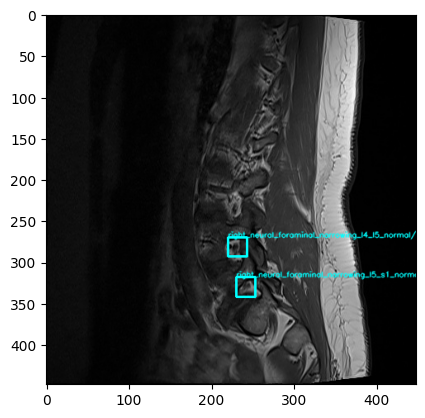

In [24]:
_IM_DIR = f'{DATA_DIR}/images/train'
_ANN_DIR = f'{DATA_DIR}/labels/train'
name = np.random.choice(os.listdir(_IM_DIR))[:-4]

im = plt.imread(os.path.join(_IM_DIR, name + '.jpg')).copy()
H, W = im.shape[:2]
anns = np.loadtxt(os.path.join(_ANN_DIR, name + '.txt')).reshape(-1, 5)

for _cls, x, y, w, h in anns.tolist():
    x *= W
    y *= H
    w *= W
    h *= H
    x1 = int(x - w / 2)
    x2 = int(x + w / 2)
    y1 = int(y - h / 2)
    y2 = int(y + h / 2)
    label = id2label[_cls]
    c = (0, 255, 255)

    im = cv2.rectangle(im, (x1, y1), (x2, y2), c, 2)
    cv2.putText(im, label, (x1, y1), fontFace, 0.3, c, 1, cv2.LINE_AA)

plt.imshow(im)

In [25]:
for k, v in id2label.items():
    print(f'{k}: {v}')

0: left_neural_foraminal_narrowing_l1_l2_normal/mild
1: left_neural_foraminal_narrowing_l1_l2_moderate
2: left_neural_foraminal_narrowing_l1_l2_severe
3: left_neural_foraminal_narrowing_l2_l3_normal/mild
4: left_neural_foraminal_narrowing_l2_l3_moderate
5: left_neural_foraminal_narrowing_l2_l3_severe
6: left_neural_foraminal_narrowing_l3_l4_normal/mild
7: left_neural_foraminal_narrowing_l3_l4_moderate
8: left_neural_foraminal_narrowing_l3_l4_severe
9: left_neural_foraminal_narrowing_l4_l5_normal/mild
10: left_neural_foraminal_narrowing_l4_l5_moderate
11: left_neural_foraminal_narrowing_l4_l5_severe
12: left_neural_foraminal_narrowing_l5_s1_normal/mild
13: left_neural_foraminal_narrowing_l5_s1_moderate
14: left_neural_foraminal_narrowing_l5_s1_severe
15: right_neural_foraminal_narrowing_l1_l2_normal/mild
16: right_neural_foraminal_narrowing_l1_l2_moderate
17: right_neural_foraminal_narrowing_l1_l2_severe
18: right_neural_foraminal_narrowing_l2_l3_normal/mild
19: right_neural_foraminal_n

In [26]:
!pip install -q git+https://github.com/THU-MIG/yolov10.git

In [27]:
import os
HOME = os.getcwd()

In [28]:
!mkdir -p {HOME}/weights
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10x.pt
!ls -lh {HOME}/weights

total 123M
-rw-r--r-- 1 root root 123M May 26 15:54 yolov10x.pt


In [29]:
%%writefile yolo_scs.yaml
path: /kaggle/working/data_fold0
train: images/train  
val: images/val 
test: images/val 

names:
    0: left_neural_foraminal_narrowing_l1_l2_normal/mild
    1: left_neural_foraminal_narrowing_l1_l2_moderate
    2: left_neural_foraminal_narrowing_l1_l2_severe
    3: left_neural_foraminal_narrowing_l2_l3_normal/mild
    4: left_neural_foraminal_narrowing_l2_l3_moderate
    5: left_neural_foraminal_narrowing_l2_l3_severe
    6: left_neural_foraminal_narrowing_l3_l4_normal/mild
    7: left_neural_foraminal_narrowing_l3_l4_moderate
    8: left_neural_foraminal_narrowing_l3_l4_severe
    9: left_neural_foraminal_narrowing_l4_l5_normal/mild
    10: left_neural_foraminal_narrowing_l4_l5_moderate
    11: left_neural_foraminal_narrowing_l4_l5_severe
    12: left_neural_foraminal_narrowing_l5_s1_normal/mild
    13: left_neural_foraminal_narrowing_l5_s1_moderate
    14: left_neural_foraminal_narrowing_l5_s1_severe
    15: right_neural_foraminal_narrowing_l1_l2_normal/mild
    16: right_neural_foraminal_narrowing_l1_l2_moderate
    17: right_neural_foraminal_narrowing_l1_l2_severe
    18: right_neural_foraminal_narrowing_l2_l3_normal/mild
    19: right_neural_foraminal_narrowing_l2_l3_moderate
    20: right_neural_foraminal_narrowing_l2_l3_severe
    21: right_neural_foraminal_narrowing_l3_l4_normal/mild
    22: right_neural_foraminal_narrowing_l3_l4_moderate
    23: right_neural_foraminal_narrowing_l3_l4_severe
    24: right_neural_foraminal_narrowing_l4_l5_normal/mild
    25: right_neural_foraminal_narrowing_l4_l5_moderate
    26: right_neural_foraminal_narrowing_l4_l5_severe
    27: right_neural_foraminal_narrowing_l5_s1_normal/mild
    28: right_neural_foraminal_narrowing_l5_s1_moderate
    29: right_neural_foraminal_narrowing_l5_s1_severe

Writing yolo_scs.yaml


In [30]:
import wandb
from wandb.integration.ultralytics import add_wandb_callback

secret_value_0 = 'noooo please god'
wandb.login(key=secret_value_0)

wandb: WARNING This integration is tested and supported for ultralytics v8.0.238 and below.
wandb: WARNING             Please report any issues to https://github.com/wandb/wandb/issues with the tag `yolov8`.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [31]:
wandb.init(
    project='lsdc_yolov10x',
    group=';'.join(CONDITIONS)
)

wandb: Currently logged in as: lightsource- (lightsource-unk). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.18.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.4
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240924_150125-g3gmjo5s
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run hardy-terrain-4
wandb: ⭐️ View project at https://wandb.ai/lightsource-unk/lsdc_yolov10x
wandb: 🚀 View run at https://wandb.ai/lightsource-unk/lsdc_yolov10x/runs/g3gmjo5s


In [32]:
from ultralytics import YOLOv10

model = YOLOv10(f'{HOME}/weights/yolov10x.pt')
add_wandb_callback(model, enable_model_checkpointing=True)

model.train(
    project='lsdc_yolov10',
    data='yolo_scs.yaml',
    epochs=EPOCHS,
    imgsz=OD_INPUT_SIZE,
    batch=BATCH_SIZE,
    optimizer='AdamW',
    seed=52,
    cos_lr=True,
    device=[0, 1]
)

wandb.finish()

New https://pypi.org/project/ultralytics/8.2.100 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
                                                      CUDA:1 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/working/weights/yolov10x.pt, data=yolo_scs.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=384, save=True, save_period=-1, val_period=1, cache=False, device=[0, 1], workers=8, project=lsdc_yolov10, name=train, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=52, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, vi

100%|██████████| 755k/755k [00:00<00:00, 15.4MB/s]
2024-09-24 15:01:45,304	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-09-24 15:01:46,217	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-09-24 15:01:49.217645: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-24 15:01:49.217775: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-24 15:01:49.404442: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS facto

Overriding model.yaml nc=80 with nc=30

                   from  n    params  module                                       arguments                     
  0                  -1  1      2320  ultralytics.nn.modules.conv.Conv             [3, 80, 3, 2]                 
  1                  -1  1    115520  ultralytics.nn.modules.conv.Conv             [80, 160, 3, 2]               
  2                  -1  3    436800  ultralytics.nn.modules.block.C2f             [160, 160, 3, True]           
  3                  -1  1    461440  ultralytics.nn.modules.conv.Conv             [160, 320, 3, 2]              
  4                  -1  6   3281920  ultralytics.nn.modules.block.C2f             [320, 320, 6, True]           
  5                  -1  1    213120  ultralytics.nn.modules.block.SCDown          [320, 640, 3, 2]              
  6                  -1  6   4604160  ultralytics.nn.modules.block.C2fCIB          [640, 640, 6, True]           
  7                  -1  1    417920  ultralytic

2024-09-24 15:02:10.562196: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-24 15:02:10.562259: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-24 15:02:10.564087: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorBoard: Start with 'tensorboard --logdir lsdc_yolov10/train', view at http://localhost:6006/


wandb: Currently logged in as: lightsource- (lightsource-unk). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.18.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.4
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240924_150213-atwwdioo
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run train
wandb: ⭐️ View project at https://wandb.ai/lightsource-unk/lsdc_yolov10
wandb: 🚀 View run at https://wandb.ai/lightsource-unk/lsdc_yolov10/runs/atwwdioo


Overriding model.yaml nc=80 with nc=30
Transferred 1123/1135 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...


100%|██████████| 6.23M/6.23M [00:00<00:00, 75.7MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/data_fold0/labels/train... 6621 images, 15 backgrounds, 0 corrupt: 100%|██████████| 6621/6621 [00:05<00:00, 1284.62it/s]


train: New cache created: /kaggle/working/data_fold0/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/data_fold0/labels/val... 1661 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1661/1661 [00:01<00:00, 1209.16it/s]


val: New cache created: /kaggle/working/data_fold0/labels/val.cache
Plotting labels to lsdc_yolov10/train/labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.937) with parameter groups 185 weight(decay=0.0), 198 weight(decay=0.0005), 197 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 384 train, 384 val
Using 4 dataloader workers
Logging results to lsdc_yolov10/train
Starting training for 100 epochs...

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      1/100      4.95G      2.227      2.832      1.085       2.17      3.055      1.017         36        384: 100%|██████████| 414/414 [02:25<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:47<00:00,  2.21it/s]


                   all       1661       3950       0.25    0.00208   7.73e-05    1.2e-05

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      2/100      5.27G      2.021        2.4      1.019          2      2.534     0.9748         37        384: 100%|██████████| 414/414 [02:13<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.25it/s]


                   all       1661       3950      0.396      0.181     0.0686     0.0269

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      3/100      5.26G      1.955      2.234      1.006      1.964      2.323     0.9675         16        384: 100%|██████████| 414/414 [02:08<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.25it/s]


                   all       1661       3950      0.436      0.224     0.0944     0.0392

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      4/100      5.27G      1.854      2.127     0.9846      1.833      2.223     0.9397         28        384: 100%|██████████| 414/414 [02:07<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.24it/s]


                   all       1661       3950      0.381      0.308      0.166      0.069

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      5/100      5.27G      1.801      2.047     0.9716      1.794      2.151     0.9328         34        384: 100%|██████████| 414/414 [02:06<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.24it/s]


                   all       1661       3950      0.331      0.279      0.153     0.0662

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      6/100      5.26G      1.794      1.999     0.9734      1.762      2.075     0.9279         20        384: 100%|██████████| 414/414 [02:07<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.24it/s]


                   all       1661       3950      0.454      0.333      0.194     0.0918

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      7/100      5.27G      1.776      1.972     0.9724      1.748      2.056     0.9271         28        384: 100%|██████████| 414/414 [02:06<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.24it/s]


                   all       1661       3950      0.504      0.273      0.177     0.0821

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      8/100      5.26G      1.767      1.982     0.9686      1.749      2.042     0.9235         17        384: 100%|██████████| 414/414 [02:07<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.24it/s]


                   all       1661       3950      0.257      0.255      0.153     0.0578

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      9/100      5.26G      1.749      1.939     0.9662      1.708       2.01     0.9173         28        384: 100%|██████████| 414/414 [02:07<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.24it/s]


                   all       1661       3950      0.278      0.392      0.204      0.102

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     10/100      5.27G      1.725      1.888      0.961       1.68      1.958     0.9163         30        384: 100%|██████████| 414/414 [02:06<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.24it/s]


                   all       1661       3950      0.361      0.356      0.207      0.102

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     11/100      5.26G      1.704       1.89     0.9595      1.671       1.94     0.9166         18        384: 100%|██████████| 414/414 [02:07<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.24it/s]


                   all       1661       3950      0.334      0.434      0.222      0.105

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     12/100      5.27G      1.695      1.842     0.9541      1.652      1.897     0.9102         13        384: 100%|██████████| 414/414 [02:07<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.24it/s]


                   all       1661       3950      0.267      0.458      0.224      0.108

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     13/100      5.27G       1.66      1.841      0.947      1.627      1.895     0.9051         15        384: 100%|██████████| 414/414 [02:07<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.24it/s]


                   all       1661       3950       0.38      0.403      0.209     0.0892

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     14/100      5.26G      1.681       1.84     0.9549      1.639      1.905     0.9108         19        384: 100%|██████████| 414/414 [02:07<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.24it/s]


                   all       1661       3950      0.286      0.462      0.225       0.11

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     15/100      5.29G      1.653      1.841     0.9463      1.624      1.884     0.9036         36        384: 100%|██████████| 414/414 [02:07<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.23it/s]


                   all       1661       3950      0.324      0.422      0.224      0.112

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     16/100      5.27G      1.656       1.81     0.9504      1.615      1.867     0.9072         27        384: 100%|██████████| 414/414 [02:07<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.24it/s]


                   all       1661       3950      0.325      0.437       0.23      0.106

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     17/100      5.26G      1.643      1.816     0.9464      1.605       1.87     0.9036         34        384: 100%|██████████| 414/414 [02:07<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.23it/s]


                   all       1661       3950      0.293      0.463      0.231      0.116

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     18/100      5.27G      1.642       1.79     0.9466      1.616      1.845     0.9061         20        384: 100%|██████████| 414/414 [02:07<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.24it/s]


                   all       1661       3950      0.317      0.454      0.244      0.119

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     19/100      5.27G      1.633       1.81     0.9431        1.6      1.849     0.9006         36        384: 100%|██████████| 414/414 [02:08<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.24it/s]


                   all       1661       3950      0.204      0.405      0.198     0.0928

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     20/100      5.26G      1.649      1.825     0.9432      1.601      1.876     0.8991         27        384: 100%|██████████| 414/414 [02:07<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.23it/s]


                   all       1661       3950       0.28      0.434      0.232      0.116

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     21/100      5.29G      1.622      1.771     0.9436      1.577      1.808     0.9003         23        384: 100%|██████████| 414/414 [02:07<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.24it/s]


                   all       1661       3950      0.311      0.469      0.226      0.114

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     22/100      5.27G      1.615      1.742     0.9423      1.581      1.781      0.902         20        384: 100%|██████████| 414/414 [02:08<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.24it/s]


                   all       1661       3950      0.313       0.43      0.235      0.111

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     23/100      5.27G      1.629      1.764     0.9456       1.59       1.82     0.9033         25        384: 100%|██████████| 414/414 [02:07<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.24it/s]


                   all       1661       3950      0.378      0.449      0.238      0.123

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     24/100      5.27G      1.613      1.769     0.9389      1.562      1.817     0.8952         21        384: 100%|██████████| 414/414 [02:07<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.24it/s]


                   all       1661       3950      0.273      0.469      0.235      0.118

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     25/100      5.27G      1.627       1.75     0.9398      1.582      1.789     0.8969         25        384: 100%|██████████| 414/414 [02:07<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.24it/s]


                   all       1661       3950      0.245      0.448      0.237      0.118

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     26/100      5.27G      1.567      1.739     0.9321      1.532      1.773     0.8913         31        384: 100%|██████████| 414/414 [02:08<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.24it/s]


                   all       1661       3950      0.369      0.422      0.236      0.111


  0%|          | 0/414 [00:00<?, ?it/s]


      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     27/100      5.26G      1.577      1.745      0.934      1.537      1.783     0.8924         14        384: 100%|██████████| 414/414 [02:07<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.24it/s]


                   all       1661       3950      0.321      0.462      0.249      0.127

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     28/100      5.27G      1.598       1.73     0.9367      1.565       1.76     0.8966         29        384: 100%|██████████| 414/414 [02:07<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.24it/s]


                   all       1661       3950      0.224      0.461      0.239       0.12

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     29/100      5.27G        1.6      1.727     0.9396      1.559      1.764     0.8959         10        384: 100%|██████████| 414/414 [02:07<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.23it/s]


                   all       1661       3950       0.31      0.456      0.237       0.12

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     30/100      5.27G      1.582       1.71     0.9348      1.556      1.751     0.8958         21        384: 100%|██████████| 414/414 [02:07<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.23it/s]


                   all       1661       3950       0.32      0.468       0.24      0.118

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     31/100      5.27G      1.579      1.728     0.9349      1.548      1.762     0.8943         19        384: 100%|██████████| 414/414 [02:07<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.24it/s]


                   all       1661       3950      0.291      0.471      0.246      0.115

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     32/100      5.27G       1.57      1.727     0.9356      1.536      1.758     0.8935         16        384: 100%|██████████| 414/414 [02:08<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.24it/s]


                   all       1661       3950      0.342       0.48      0.247      0.127

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     33/100      5.28G      1.566      1.716     0.9312       1.53      1.753     0.8923         30        384: 100%|██████████| 414/414 [02:08<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.24it/s]


                   all       1661       3950      0.359      0.432      0.235      0.112

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     34/100      5.27G      1.559      1.704     0.9313      1.509      1.745     0.8894         12        384: 100%|██████████| 414/414 [02:07<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.24it/s]


                   all       1661       3950      0.297      0.467      0.243      0.122

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     35/100      5.27G      1.557      1.696     0.9299      1.514      1.728     0.8916         27        384: 100%|██████████| 414/414 [02:08<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.24it/s]


                   all       1661       3950        0.3      0.438      0.249      0.123

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     36/100      5.27G      1.551      1.703     0.9305      1.509      1.729     0.8885         24        384: 100%|██████████| 414/414 [02:08<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.23it/s]


                   all       1661       3950      0.204      0.456      0.244      0.121

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     37/100      5.27G       1.55      1.685     0.9286      1.532      1.711     0.8914         27        384: 100%|██████████| 414/414 [02:07<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.24it/s]


                   all       1661       3950      0.272      0.459      0.246      0.122

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     38/100      5.27G      1.547      1.663     0.9283      1.496      1.702     0.8866         23        384: 100%|██████████| 414/414 [02:08<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.24it/s]


                   all       1661       3950      0.296      0.452      0.247      0.129

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     39/100      5.29G      1.541      1.678     0.9264      1.505      1.717     0.8883         18        384: 100%|██████████| 414/414 [02:08<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.23it/s]


                   all       1661       3950       0.26       0.46      0.256      0.135

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     40/100      5.27G       1.54      1.695     0.9279      1.497      1.719     0.8871         18        384: 100%|██████████| 414/414 [02:08<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.24it/s]


                   all       1661       3950      0.306      0.471      0.256      0.132

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     41/100      5.27G      1.541      1.667     0.9284      1.498      1.714     0.8873         27        384: 100%|██████████| 414/414 [02:09<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.23it/s]


                   all       1661       3950      0.281       0.46      0.265      0.139

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     42/100      5.27G      1.521      1.655     0.9269      1.489      1.683     0.8899         13        384: 100%|██████████| 414/414 [02:09<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.24it/s]


                   all       1661       3950      0.297      0.462       0.27      0.138

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     43/100      5.27G      1.528      1.651     0.9246      1.487      1.684      0.885         20        384: 100%|██████████| 414/414 [02:09<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.23it/s]


                   all       1661       3950      0.226      0.461       0.28      0.144

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     44/100      5.27G      1.529       1.62     0.9232      1.484      1.641     0.8828         20        384: 100%|██████████| 414/414 [02:09<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.23it/s]


                   all       1661       3950      0.287      0.465      0.294      0.148

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     45/100      5.27G       1.52      1.628     0.9242      1.485      1.655     0.8848         25        384: 100%|██████████| 414/414 [02:09<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.24it/s]


                   all       1661       3950      0.338      0.457      0.304      0.155

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     46/100      5.26G      1.546      1.642     0.9258      1.507      1.652     0.8861         25        384: 100%|██████████| 414/414 [02:09<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.23it/s]


                   all       1661       3950      0.345      0.448      0.311      0.166

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     47/100      5.27G      1.524      1.568      0.924      1.478      1.593     0.8828         26        384: 100%|██████████| 414/414 [02:09<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.24it/s]


                   all       1661       3950      0.371      0.468      0.346      0.181

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     48/100      5.27G      1.491       1.55     0.9209      1.469      1.584     0.8852         11        384: 100%|██████████| 414/414 [02:08<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.23it/s]


                   all       1661       3950      0.382      0.483      0.379      0.197

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     49/100      5.27G      1.512      1.519     0.9243      1.463      1.536     0.8828         39        384: 100%|██████████| 414/414 [02:09<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.24it/s]


                   all       1661       3950      0.488      0.462      0.409      0.206

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     50/100      5.27G      1.495      1.485     0.9178      1.468      1.492     0.8841         24        384: 100%|██████████| 414/414 [02:08<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.23it/s]


                   all       1661       3950      0.444      0.508      0.422      0.219

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     51/100      5.26G        1.5      1.432     0.9143      1.466      1.456     0.8769         29        384: 100%|██████████| 414/414 [02:08<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.24it/s]


                   all       1661       3950      0.479      0.519      0.435      0.223

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     52/100      5.26G      1.505      1.421     0.9212      1.484      1.433     0.8851         28        384: 100%|██████████| 414/414 [02:09<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.24it/s]


                   all       1661       3950      0.472      0.471       0.44      0.229

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     53/100      5.26G       1.51      1.408     0.9246      1.458      1.434     0.8843         14        384: 100%|██████████| 414/414 [02:08<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.23it/s]


                   all       1661       3950      0.449      0.497      0.427      0.225

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     54/100      5.27G      1.507       1.39     0.9199      1.473      1.408      0.883         20        384: 100%|██████████| 414/414 [02:09<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.23it/s]


                   all       1661       3950      0.441      0.513      0.445       0.23

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     55/100      5.27G      1.499      1.393     0.9225      1.458      1.401     0.8835         39        384: 100%|██████████| 414/414 [02:09<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.23it/s]


                   all       1661       3950      0.496      0.485      0.448      0.235

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     56/100      5.27G      1.495      1.387     0.9184      1.471      1.391     0.8844         23        384: 100%|██████████| 414/414 [02:08<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.24it/s]


                   all       1661       3950      0.491      0.495      0.452      0.237

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     57/100      5.27G      1.489      1.354     0.9168       1.45       1.38     0.8784         22        384: 100%|██████████| 414/414 [02:08<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.23it/s]


                   all       1661       3950      0.446      0.534      0.455      0.238

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     58/100      5.27G      1.493       1.36      0.924      1.464      1.371     0.8853         29        384: 100%|██████████| 414/414 [02:09<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.23it/s]


                   all       1661       3950      0.454      0.522      0.463      0.244

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     59/100      5.27G      1.486      1.339     0.9209      1.455      1.355     0.8849         19        384: 100%|██████████| 414/414 [02:09<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.24it/s]


                   all       1661       3950      0.451      0.537      0.464      0.243

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     60/100      5.27G      1.467      1.336     0.9146      1.434      1.335      0.879         36        384: 100%|██████████| 414/414 [02:09<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.24it/s]


                   all       1661       3950      0.437      0.517      0.458      0.236

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     61/100      5.27G      1.482      1.311     0.9198      1.437      1.338     0.8823         37        384: 100%|██████████| 414/414 [02:09<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.23it/s]


                   all       1661       3950      0.466      0.538      0.471      0.243

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     62/100      5.27G      1.467       1.31     0.9162      1.437       1.33     0.8788         20        384: 100%|██████████| 414/414 [02:09<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.23it/s]


                   all       1661       3950      0.499      0.532      0.467      0.242

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     63/100      5.27G      1.469      1.331     0.9175      1.433      1.353       0.88         18        384: 100%|██████████| 414/414 [02:09<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.24it/s]


                   all       1661       3950      0.409      0.558      0.468      0.245

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     64/100      5.27G      1.475      1.292     0.9157       1.43      1.306      0.878         19        384: 100%|██████████| 414/414 [02:09<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.23it/s]


                   all       1661       3950      0.463      0.527      0.468      0.241

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     65/100      5.27G      1.464      1.295     0.9136       1.43      1.297     0.8748         36        384: 100%|██████████| 414/414 [02:09<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.24it/s]


                   all       1661       3950      0.482      0.522      0.464      0.239

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     66/100      5.27G      1.471      1.279     0.9173      1.431        1.3     0.8811         20        384: 100%|██████████| 414/414 [02:09<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.24it/s]


                   all       1661       3950        0.4      0.552      0.464      0.244

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     67/100      5.29G      1.457      1.299     0.9138      1.424      1.322     0.8765         31        384: 100%|██████████| 414/414 [02:09<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.23it/s]


                   all       1661       3950      0.431      0.532       0.46      0.238

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     68/100      5.27G      1.437      1.275     0.9097      1.412      1.286     0.8769         25        384: 100%|██████████| 414/414 [02:09<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.23it/s]


                   all       1661       3950      0.441      0.505      0.465      0.238

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     69/100      5.27G      1.447      1.265     0.9085      1.417      1.293     0.8721         27        384: 100%|██████████| 414/414 [02:08<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.23it/s]


                   all       1661       3950      0.434      0.526      0.469      0.242

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     70/100      5.27G      1.452      1.276     0.9098       1.41      1.279      0.873         32        384: 100%|██████████| 414/414 [02:09<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.23it/s]


                   all       1661       3950      0.485      0.512      0.467      0.239

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     71/100      5.27G      1.436       1.24     0.9103      1.408       1.26     0.8732         45        384: 100%|██████████| 414/414 [02:09<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.23it/s]


                   all       1661       3950      0.442      0.511       0.47      0.242

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     72/100      5.26G      1.448      1.263     0.9108      1.413      1.278     0.8757         49        384: 100%|██████████| 414/414 [02:09<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.23it/s]


                   all       1661       3950      0.466      0.529      0.468      0.242

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     73/100      5.27G      1.434      1.243     0.9068      1.394      1.269     0.8714         17        384: 100%|██████████| 414/414 [02:09<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.23it/s]


                   all       1661       3950       0.44      0.538      0.468      0.241

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     74/100      5.27G      1.441      1.227     0.9099      1.417      1.239     0.8734         17        384: 100%|██████████| 414/414 [02:09<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.24it/s]


                   all       1661       3950       0.43      0.539      0.468       0.24

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     75/100      5.27G       1.43      1.243     0.9097      1.407      1.252     0.8752         15        384: 100%|██████████| 414/414 [02:09<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.23it/s]


                   all       1661       3950      0.433      0.525      0.469      0.239

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     76/100      5.27G      1.429      1.227     0.9077      1.408      1.241     0.8751         32        384: 100%|██████████| 414/414 [02:09<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.23it/s]


                   all       1661       3950      0.437      0.536      0.465      0.239

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     77/100      5.27G      1.421      1.221     0.9063      1.397      1.234     0.8728         36        384: 100%|██████████| 414/414 [02:09<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.23it/s]


                   all       1661       3950      0.431      0.541      0.466       0.24

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     78/100      5.29G      1.432      1.215     0.9114      1.407      1.241      0.876         24        384: 100%|██████████| 414/414 [02:09<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.23it/s]


                   all       1661       3950      0.437      0.536      0.468      0.242

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     79/100      5.27G      1.432      1.231     0.9076      1.398      1.253     0.8726         22        384: 100%|██████████| 414/414 [02:08<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.24it/s]


                   all       1661       3950      0.433       0.54       0.47      0.241

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     80/100      5.26G      1.419      1.186     0.9074      1.385       1.21     0.8713         21        384: 100%|██████████| 414/414 [02:09<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.24it/s]


                   all       1661       3950      0.436      0.547      0.469      0.239

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     81/100      5.27G      1.424      1.214     0.9101      1.388      1.239     0.8732         26        384: 100%|██████████| 414/414 [02:09<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.23it/s]


                   all       1661       3950      0.445      0.528      0.469       0.24

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     82/100      5.27G       1.42      1.217     0.9079      1.396      1.231     0.8743         15        384: 100%|██████████| 414/414 [02:09<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.23it/s]


                   all       1661       3950      0.439      0.531      0.465      0.238

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     83/100      5.27G      1.408      1.204     0.9042      1.385      1.218     0.8705         24        384: 100%|██████████| 414/414 [02:09<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.23it/s]


                   all       1661       3950      0.434      0.531      0.465      0.238

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     84/100      5.27G      1.413      1.208     0.9086      1.388      1.228     0.8755         20        384: 100%|██████████| 414/414 [02:10<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.23it/s]


                   all       1661       3950      0.425      0.534      0.464      0.237

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     85/100      5.27G      1.404      1.207     0.9075      1.372      1.222     0.8707         21        384: 100%|██████████| 414/414 [02:10<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.23it/s]


                   all       1661       3950      0.422      0.545      0.461      0.236

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     86/100      5.26G      1.397      1.192     0.8996      1.375       1.21     0.8674         26        384: 100%|██████████| 414/414 [02:09<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.23it/s]


                   all       1661       3950      0.429      0.539       0.46      0.236

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     87/100      5.26G      1.407      1.189     0.8982      1.375      1.223     0.8676         32        384: 100%|██████████| 414/414 [02:08<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.23it/s]


                   all       1661       3950      0.422      0.535      0.454      0.233

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     88/100      5.27G       1.39      1.166      0.897      1.365      1.186     0.8646         20        384: 100%|██████████| 414/414 [02:09<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.24it/s]


                   all       1661       3950      0.428      0.539      0.445      0.229

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     89/100      5.27G       1.41      1.184     0.9098       1.39      1.196     0.8745         24        384: 100%|██████████| 414/414 [02:09<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.23it/s]


                   all       1661       3950      0.424      0.547      0.449      0.231

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     90/100      5.27G      1.406      1.167     0.9064      1.388      1.188     0.8752         23        384: 100%|██████████| 414/414 [02:09<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.23it/s]


                   all       1661       3950      0.432      0.539      0.454      0.233
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     91/100      5.26G      1.427      1.111     0.9349      1.392      1.099     0.8957         19        384: 100%|██████████| 414/414 [02:09<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.23it/s]


                   all       1661       3950      0.422      0.544      0.449      0.232

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     92/100      5.27G      1.397      1.094     0.9288      1.369      1.089     0.8947         19        384: 100%|██████████| 414/414 [02:09<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.23it/s]


                   all       1661       3950      0.428      0.534       0.45      0.231

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     93/100      5.27G        1.4      1.095     0.9333      1.352      1.082     0.8938         22        384: 100%|██████████| 414/414 [02:08<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.23it/s]


                   all       1661       3950       0.43      0.524      0.447       0.23

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     94/100      5.26G      1.403      1.109     0.9348      1.357      1.097     0.8935         18        384: 100%|██████████| 414/414 [02:09<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.23it/s]


                   all       1661       3950      0.428      0.516      0.441      0.227

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     95/100      5.27G      1.394        1.1     0.9311      1.352      1.095     0.8909         17        384: 100%|██████████| 414/414 [02:08<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.23it/s]


                   all       1661       3950      0.422       0.52      0.442      0.228

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     96/100      5.27G      1.388       1.09     0.9305      1.347      1.091     0.8923         16        384: 100%|██████████| 414/414 [02:08<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.23it/s]


                   all       1661       3950      0.421      0.532      0.442      0.228

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     97/100      5.27G      1.387      1.093     0.9335      1.337      1.095     0.8932         17        384: 100%|██████████| 414/414 [02:09<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.23it/s]


                   all       1661       3950      0.419      0.529      0.441      0.228

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     98/100      5.26G      1.383      1.083     0.9324      1.334      1.089      0.893         15        384: 100%|██████████| 414/414 [02:09<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.23it/s]


                   all       1661       3950      0.424      0.532      0.443      0.229

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     99/100      5.26G      1.387      1.094     0.9306      1.343      1.099     0.8921         19        384: 100%|██████████| 414/414 [02:09<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.23it/s]


                   all       1661       3950      0.422      0.532      0.442      0.229

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


    100/100      5.27G      1.382      1.089      0.926      1.339      1.088     0.8888         14        384: 100%|██████████| 414/414 [02:09<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:46<00:00,  2.24it/s]


                   all       1661       3950      0.417      0.538      0.441      0.228

100 epochs completed in 5.002 hours.
Optimizer stripped from lsdc_yolov10/train/weights/last.pt, 64.2MB
Optimizer stripped from lsdc_yolov10/train/weights/best.pt, 64.2MB

Validating lsdc_yolov10/train/weights/best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
                                                      CUDA:1 (Tesla T4, 15095MiB)
YOLOv10x summary (fused): 503 layers, 31641860 parameters, 0 gradients, 170.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:47<00:00,  2.20it/s]


                   all       1661       3950      0.459      0.554      0.472      0.237
left_neural_foraminal_narrowing_l1_l2_normal/mild       1661        380      0.534      0.833      0.716      0.354
left_neural_foraminal_narrowing_l1_l2_moderate       1661         15      0.437        0.4      0.384      0.187
left_neural_foraminal_narrowing_l2_l3_normal/mild       1661        358      0.602      0.855      0.708       0.37
left_neural_foraminal_narrowing_l2_l3_moderate       1661         34      0.397      0.471      0.386       0.18
left_neural_foraminal_narrowing_l2_l3_severe       1661          3          1          0      0.117     0.0469
left_neural_foraminal_narrowing_l3_l4_normal/mild       1661        305      0.548      0.839      0.692       0.37
left_neural_foraminal_narrowing_l3_l4_moderate       1661         83      0.318      0.422      0.324       0.16
left_neural_foraminal_narrowing_l3_l4_severe       1661          7      0.686      0.571      0.575      0.249
le

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                  lr/pg1 ▃███████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
wandb:                  lr/pg2 ▃███████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
wandb:        metrics/mAP50(B) ▁▂▄▃▄▄▄▅▄▅▄▅▅▅▅▅▅▅▆▇▇███████████████████
wandb:     metrics/mAP50-95(B) ▁▂▄▃▄▄▄▄▄▅▄▄▄▅▄▅▅▅▆▇▇███████████████████
wandb:    metrics/precision(B) ▂▇▇▂▄▅▄▄▄▅▅▁▃▃▁▂▃▃▄██▇█▇▇▇▇▇▇▆▇▇▇▆▆▆▆▆▆▇
wandb:       metrics/recall(B) ▁▄▅▄▆▆▇▇▇��▆▇▇▇▇▇▇▇▇▇█▇▇█████████████████
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:            train/box_om █▆▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
wandb:            train/box_oo █▆▅▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
wandb:            train/cls_om █▆▅▅▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
wandb:            train/cls_oo █▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁

left_neural_foraminal_narrowing_l3_l4_normal/mild
left_neural_foraminal_narrowing_l4_l5_normal/mild
left_neural_foraminal_narrowing_l5_s1_moderate


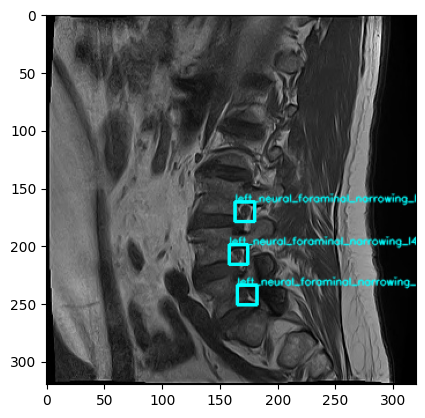

In [33]:
_IM_DIR = f'{DATA_DIR}/images/val'
_ANN_DIR = f'{DATA_DIR}/labels/val'
name = np.random.choice(os.listdir(_IM_DIR))[:-4]

path = os.path.join(_IM_DIR, name + '.jpg')

im = plt.imread(path).copy()
H, W = im.shape[:2]
anns = np.loadtxt(os.path.join(_ANN_DIR, name + '.txt')).reshape(-1, 5)

for _cls, x, y, w, h in anns.tolist():
    x *= W
    y *= H
    w *= W
    h *= H
    x1 = int(x - w / 2)
    x2 = int(x + w / 2)
    y1 = int(y - h / 2)
    y2 = int(y + h / 2)
    label = id2label[_cls]
    print(label)

    c = (0, 255, 255)

    im = cv2.rectangle(im, (x1, y1), (x2, y2), c, 2)
    cv2.putText(im, label, (x1, y1), fontFace, 0.3, c, 1, cv2.LINE_AA)

plt.imshow(im)

In [34]:
model = YOLOv10(glob.glob('lsdc_yolov10/*/weights/best.pt')[0])
out = model.predict([path], save=True, conf=0.2)

wandb.finish()


0: 384x384 1 left_neural_foraminal_narrowing_l3_l4_normal/mild, 1 left_neural_foraminal_narrowing_l3_l4_moderate, 1 left_neural_foraminal_narrowing_l4_l5_normal/mild, 1 left_neural_foraminal_narrowing_l4_l5_moderate, 1 left_neural_foraminal_narrowing_l5_s1_moderate, 36.3ms
Speed: 3.1ms preprocess, 36.3ms inference, 55.6ms postprocess per image at shape (1, 3, 384, 384)
Results saved to runs/detect/predict


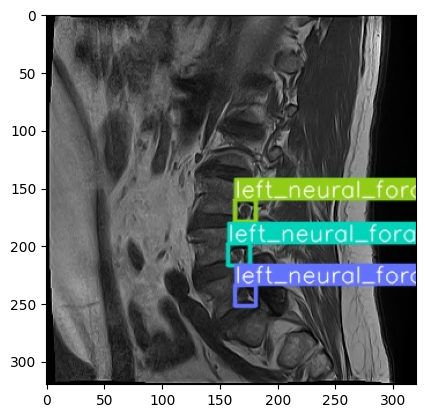

In [35]:
im = plt.imread(glob.glob(f'{out[0].save_dir}/*.jpg')[0])
plt.imshow(im)